# Generating simple cross sections

Here we show how you can generate collisional cross sections using the tools from `parfis` module. Since the collisional therms span for a wide range of nonlinear functions, we will use logartihmic scales.

## Generating constant and step collision cross section

In order to choose the range of energies for the cross section, we can use the simulation parameters. A particle is bounded for the value of the velocty vector as it must not traverse more than a cell-length in a single timestep. Let's have the following simulation settings:

\begin{align} 
  C = C_x &= C_y = C_z = 0.02 \mathrm{m}, \\
  \Delta t &= 10^{-10} \mathrm{s}, \\
   m_e &= 9.1093837 \cdot 10^{-31} \mathrm{kg},
\end{align}

for the cell size, timestep and particle mass (electron). We can calculate the maximum velocity component as $v_m = C/\Delta t$ from which we get the maximum kinetic energy that can be simulated per electron as:

$$
E_{m} = \frac{1}{2} m_e v^2 = \frac{3}{2} m_e \left( \frac{C}{\Delta t} \right)^2 = 5.465630\cdot10^{-14} \mathrm{J} \quad (\equiv 341.1378 \mathrm{keV}).
$$

From this we can say that the x vector should go from 0 to 342keV.

### Constant cross section 

We will generate elastic cross section with a value of:

$$\sigma_e = 6 \mathrm{\AA^2} \quad (\equiv 6.0 \cdot 10^{-20} \mathrm{m^2}).$$

### Step cross section

For the step cross section we have a point at which the value has a discontinity. This cross section will have a threshold, and the collision process is inelastic. The function of the step cross section is:

$$ \sigma_i = 
\begin{cases}
  0 \quad &x < 0.2 \mathrm{eV} \\
  3  \mathrm{\AA^2} \quad &x \geq 0.2 \mathrm{eV}.
\end{cases}
$$




In [1]:
import parfis as pfs
import matplotlib.pyplot as plt
import numpy as np

nbin = 10000 # number of bins
xmax = 342_000
dx = np.log10(xmax)/nbin # dx for the linear axis
xvec = [np.power(i*dx, 10) for i in range(nbin)]

def sigma_e(x):
    return 6

def sigma_i(x):
    if x<0.2:
        return 0
    else:
        return 3

x = np.asarray(xvec)
ye = np.ndarray(len(xvec), dtype=float)
yi = np.ndarray(len(xvec), dtype=float)
for i in range(len(xvec)):
    ye[i] = sigma_e(xvec[i])
    yi[i] = sigma_i(xvec[i])
yt = ye + yi

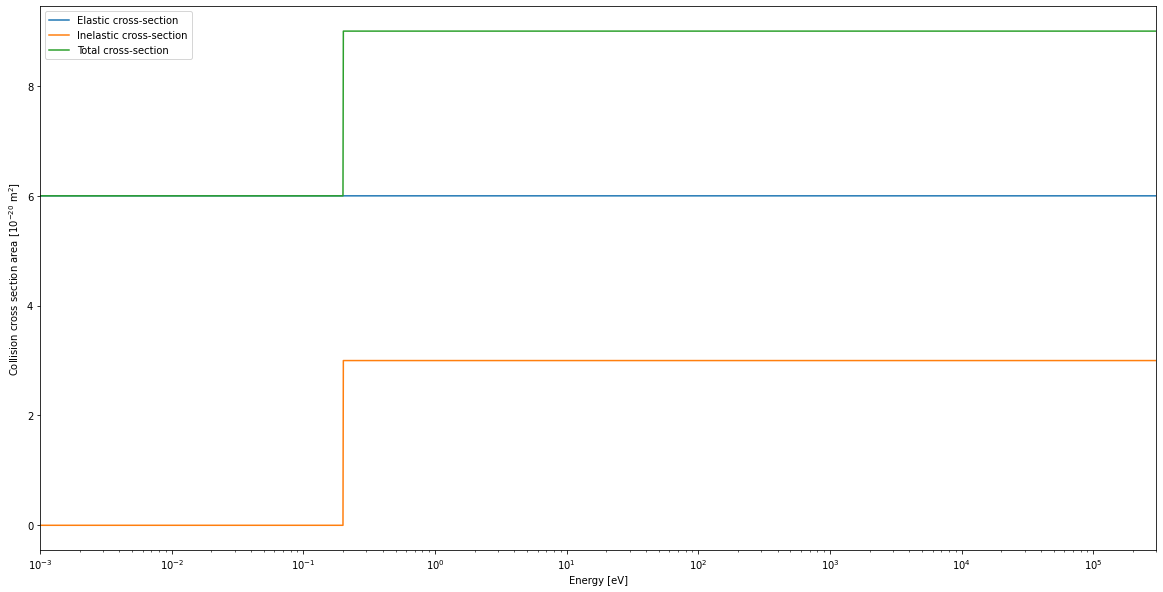

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.plot(x, ye, label="Elastic cross-section")
ax.plot(x, yi, label="Inelastic cross-section")
ax.plot(x, yt, label="Total cross-section")
ax.set_xscale("log")
ax.set_xlim(0.001, 300_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()

### Collision frequency

The probability for a collision in a time $\Delta t$ is given as:

$$
p(t, t + \Delta t) = 1 - \exp( -N \sigma_t  v \Delta t ) = 1 - \exp(-\nu_t \Delta_t),
$$

where $N$ is the number of gas particles, $v$ is the velocity magnitude of the projectile particle and $\nu_t$ is the collisional frequency. We can express the above collisional frequencies by using the formula $v = 2 \sqrt{\epsilon} / m_e$.

$$
\nu(\epsilon) = N \sigma(\epsilon) \frac{2 \sqrt{\epsilon}}{m_e}.
$$

We calculate collisional frequency for Avogadro number of particles $N_A$:

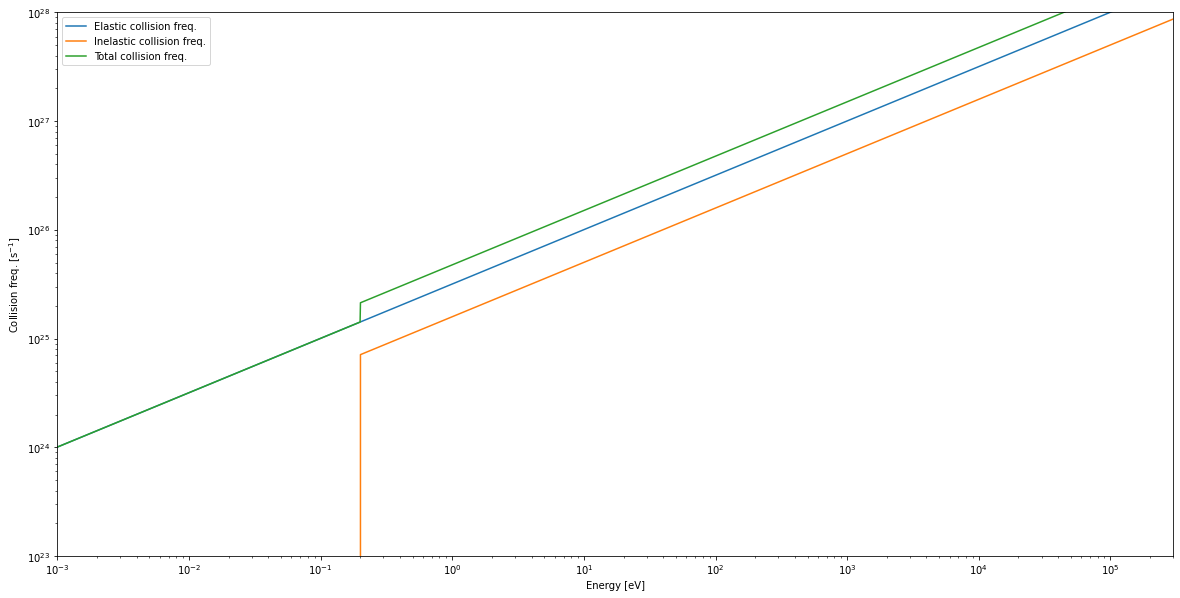

In [3]:
eVJ = 1.602176634e-19
me = 9.1093837e-11  # since we have y in units of A^2 (scale 1e-20m) and me in kg (scale 1e-31)
Na = 6.02214076e23

nue = Na*ye*2*np.sqrt(x*eVJ)/me
nui = Na*yi*2*np.sqrt(x*eVJ)/me
nut = Na*yt*2*np.sqrt(x*eVJ)/me


fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.plot(x, nue, label="Elastic collision freq.")
ax.plot(x, nui, label="Inelastic collision freq.")
ax.plot(x, nut, label="Total collision freq.")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.001, 300_000)
ax.set_ylim(1e23, 1e28)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision freq. [$\mathrm{s}^{-1}$]")
ax.legend()

plt.show()

### Mapping of log tabulated functions

Since we will use logarithmic scales for the x-axis, we can use lookup tables for faster finding the index of tabulated func. For example, if we want to find out the value of the total collisional frequency for a particle of energy $\epsilon$:

1. We find the index $i$ (from the lookup table) such that the energy $\epsilon$ lies between the two tabulated values of energy $\epsilon_i$ and $\epsilon_{i+1}$.
2. We calculate the value of $nu$ based on a linear interpolation between the tabulated values $\nu_i$ and $\nu_{i+1}$.

To create a lut table we split every order of magnitude to a number of bins. Files generated this way can be used by collision algorithms in parfis.

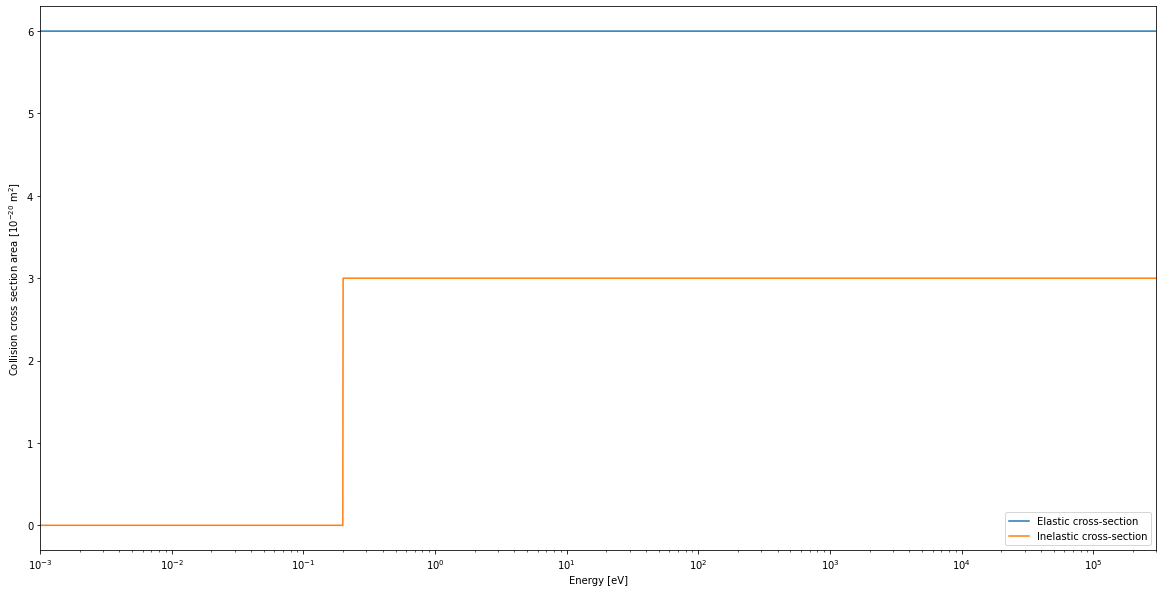

In [4]:
ranges = [   1,   10,  100, 1000, 10000, 342000]
nbins =  [1000, 1000, 1000, 1000,  1000,   3000]

x, ye = pfs.generateCrossSection(sigma_e, ranges, nbins)
x, yi = pfs.generateCrossSection(sigma_i, ranges, nbins)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.plot(x, ye, label="Elastic cross-section")
ax.plot(x, yi, label="Inelastic cross-section")

ax.set_xscale("log")
ax.set_xlim(0.001, 300_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()